# Imports and dataset download


In [ ]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import glob , os , random
from collections import Counter, OrderedDict
from operator import add, pow

In [ ]:
!pip install gdown
!gdown --id 1AFFNBHQImTmjjIlaHj4Zph4TcisjlBbu 

Downloading...
From: https://drive.google.com/uc?id=1AFFNBHQImTmjjIlaHj4Zph4TcisjlBbu
To: /content/dataset.zip
100% 886k/886k [00:00<00:00, 58.7MB/s]


In [ ]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
  inflating: dataset/nonspam (1).txt  
  inflating: dataset/nonspam (10).txt  
  inflating: dataset/nonspam (100).txt  
  inflating: dataset/nonspam (101).txt  
  inflating: dataset/nonspam (102).txt  
  inflating: dataset/nonspam (103).txt  
  inflating: dataset/nonspam (104).txt  
  inflating: dataset/nonspam (105).txt  
  inflating: dataset/nonspam (106).txt  
  inflating: dataset/nonspam (107).txt  
  inflating: dataset/nonspam (108).txt  
  inflating: dataset/nonspam (109).txt  
  inflating: dataset/nonspam (11).txt  
  inflating: dataset/nonspam (110).txt  
  inflating: dataset/nonspam (111).txt  
  inflating: dataset/nonspam (112).txt  
  inflating: dataset/nonspam (113).txt  
  inflating: dataset/nonspam (114).txt  
  inflating: dataset/nonspam (115).txt  
  inflating: dataset/nonspam (116).txt  
  inflating: dataset/nonspam (117).txt  
  inflating: dataset/nonspam (118).txt  
  inflating: dataset/nonspam (119).txt  
  inflating: dataset/nonspam (

# extracting most common words 

making vocabulary - 3000 most occuring words 

In [ ]:
all_words = []
emails = []
email_paths = glob.glob("/content/dataset/*.txt")
for f in email_paths:
  with open(f, 'r') as file:
    for line in file:
      for word in line.split():
        if(len(word) != 1):
          all_words.append(word)
  with open(f, 'r') as file:    
    emails.append(file.read()) 
occrcounts = Counter(all_words)
occrcounts = OrderedDict(occrcounts.most_common()) 
vocabulary = list(occrcounts.keys())      
vocabulary = np.array(vocabulary[:3000])

# feature vectors for each email 

In [ ]:
#extracting feature vectors 
featuresAndLabels = []  #list holding all 960 feature vectors
label = 0 
email_paths = glob.glob("/content/dataset/*.txt")
words = []
words = np.array(words)
for f in email_paths:             #looping over the emails - 960 in total 
  featureVector = [0]*3000        #individual feature vector 
  featureVector = np.array(featureVector)
  file = open(f,'r')
  if 'non' in file.name:                 #spam non spam labels 
    label = 0                    #for checking later on if a given feature vector is of spam or non spam email 
  else:
    label = 1  
  file = open(f,'r')
  words = (file.read()).split(" ")    #extracting words for comparison              
  for i in range(len(words)-1):    #feature vector loop 
    if vocabulary.__contains__(words[i]):    #if a word in vocabulary is present in an email, 
      index = np.where(vocabulary==words[i])[0][0]    
      featureVector[index] = 1            #place 1 in feature vector 
  featuresAndLabels.append([featureVector,label])  #appednding feature vectors and corresponding labels in featuresAndLabels  

In [ ]:
random.shuffle(featuresAndLabels) #shuffling feature vectors      
start = 0 
till = 120
folds_set = []
for i in range(8):
  folds_set.append(featuresAndLabels[start:till])
  start+=120
  till+=120

In [ ]:
def calculate_params(trainset):
  #returns phi0 , phi1 and phiY for one fold 
  phi0 = [0]*3000
  phi1 = [0]*3000
  phi0 = np.array(phi0) ; phi1 = np.array(phi1)
  num_spamEmails = 0     #count for number of spam emails in one fold 
  num_nonspamEmails = 0
  spam_feature_vectors = []
  nonspam_feature_vectors = []
  totalEmails = len(trainset)
  for i in range(len(trainset)):
    if trainset[i][1] == 0:                          #if non spam 
      nonspam_feature_vectors.append(trainset[i][0]) 
      num_nonspamEmails+=1                           #add feature in nonspam features list 
    else:                                            #else in spam features list 
      spam_feature_vectors.append(trainset[i][0])
      num_spamEmails+=1
  for j in range(len(nonspam_feature_vectors)):
    x = nonspam_feature_vectors[j]
    phi0 = phi0 + x    
  phi0 = phi0 + 1                     #laplace smoothening 
  phi0 = phi0/(num_nonspamEmails+2) 
  for j in range(len(spam_feature_vectors)):
    x = spam_feature_vectors[j]
    phi1 = phi1 + x 
  
  phi1 = phi1 + 1                       #laplace smoothening 
  phi1 = phi1/(num_spamEmails+2) 

  phiY = num_spamEmails/totalEmails
  return phi0, phi1, phiY


In [ ]:
#K fold validation inc training for each fold 
accuracyPerFold = []
for i in range(8):
  testset = folds_set[i]
  trainset = folds_set[:i]+folds_set[i+1:]
  fold_trainset = []
  for p in range(7):
    x = trainset[p]
    fold_trainset += x  
  phi0 , phi1 ,phiY = calculate_params(trainset=fold_trainset)
  probabilitesPerFold = [0]*120
  accuracy = 0
  for j in range(120):
    #calculating accuracy formula 
    #numerator 
    xj = testset[j][0]
    temp0 = pow(phi1,xj)
    temp1 = pow((1-phi1),(1-xj))
    temp2 = temp0*temp1
    numerator = np.sum(phiY * temp2 )
    #denominator
    #left side
    temp0 = pow(phi0,xj)
    temp1 = pow((1-phi0),(1-xj))
    temp2 = temp0 *temp1
    leftside = np.sum((1-phiY)*temp2)

    #right side
    temp0 = pow(phi1,xj) 
    temp1 = pow((1-phi1),(1-xj))
    temp2 = temp0*temp1
    rightside = np.sum(phiY * temp2)

    denominator = leftside + rightside
    probability = numerator/denominator
   # print('numerator = ',numerator,' left side = ',leftside,' right side = ',rightside) 
    if probability >= 0.5:   
      probabilitesPerFold[j] = 1
  for i in range(120):
    if probabilitesPerFold[i] == testset[i][1]:
      accuracy+=1
  accuracyPerFold.append(accuracy/120)      


In [ ]:
for i in range(len(accuracyPerFold)):
  print(accuracyPerFold[i]*100)

51.66666666666667
45.0
41.66666666666667
46.666666666666664
40.833333333333336
43.333333333333336
57.49999999999999
52.5


In [ ]:
print(np.mean(accuracyPerFold))

0.47395833333333337


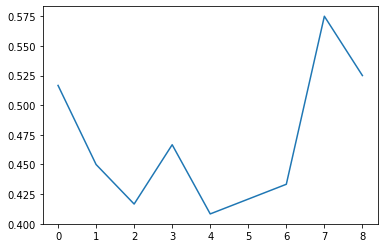

In [ ]:
folds = [0,1,2,3,4,6,7,8]
plt.plot(folds,accuracyPerFold)